In [1]:
import matplotlib.pyplot as plt
import torch
import sympy
import numpy as np

# Automatic Differentiation

Automatic differentation (AD) is a method to compute exact derivatives of computer programs. In particular,  AD enables the training of neural networks via gradient descent.  Aside from machine learning applications, AD can be used in any context where we want to efficiently and accurately compute the derivative of a computer program. This tutorial explains how AD can be applied to agent-based models (ABMs), while this first notebook introduces AD more broadly.

 Before introducing AD in full, we start by reviewing traditional approaches for differentiation.

## Finite Differences

How might we estimate the derivative in practice? Recall the definition of the derivative for univariate scalar functions:

$$ \frac{df}{dx} = \lim_{h \to 0} \frac{f(x + h) - f(x)}{h}$$

Intuitively, if we choose a small enough pertubation $\epsilon$ then we may estimate the derivative of $f$ as follows:

$$ \frac{d f}{d x} \approx  \frac{f(x+\epsilon) - f(x)}{\epsilon} $$

This is known as the finite differences (FD) method since it involves evaluating $f$ at two points spaced by a finite difference $\epsilon$. We can explore the behaviour of FD by investigating some examples. Consider the following function:

$$ f(x) = x^{4} + 4x^{2} - 10. $$

Let's implement this function in Python and estimate its gradient with FD!

In [2]:
def function(x):
    return x**3 + 4*x**2 - 10

def function_true_derivative(x):
    return 3*x**2 + 8*x

def get_fd_derivative(f, x, epsilon):
    return (f(x + epsilon) - f(x)) / (epsilon)

In [3]:
x = np.linspace(-5, 5, 10)
y = function(x)
epsilon = 1e-2
yp_true = function_true_derivative(x)
yp_fd = get_fd_derivative(function, x, epsilon)

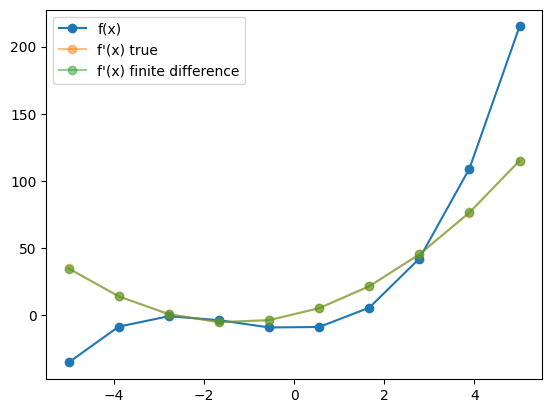

In [4]:
fig, ax = plt.subplots()
ax.plot(x, y, "o-", label='f(x)')
ax.plot(x, yp_true, "o-", label="f'(x) true", alpha=0.5)
ax.plot(x, yp_fd, "o-", label="f'(x) finite difference", alpha=0.5)
ax.legend()

In this case, FD works extremely well and matches the true analytical gradient almost exactly. Let's investigate a more complicated function with highly oscilatory behaviour:

$$ f(x) = \sin(1000x). $$

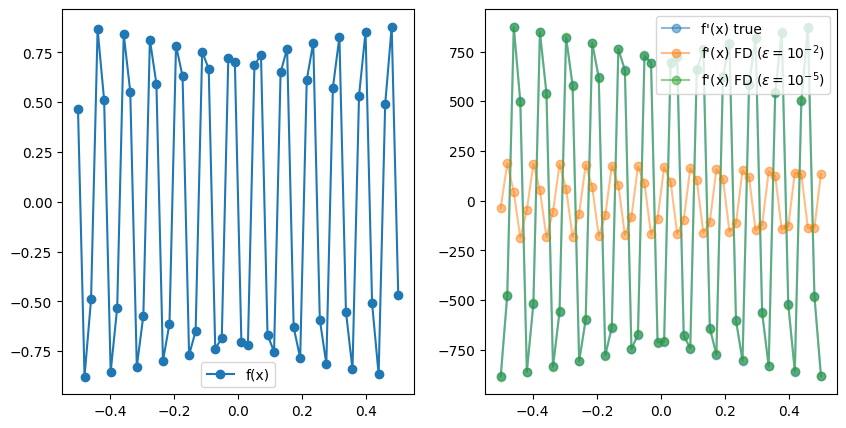

In [5]:
x = np.linspace(-0.5, 0.5, 50)
f = lambda x: np.sin(1000*x)
y = np.sin(1000*x)
yp_true = 1000 * np.cos(1000*x)
yp_fd_1 = get_fd_derivative(f, x, epsilon=1e-2)
yp_fd_2 = get_fd_derivative(f, x, epsilon=1e-5)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(x, y, "o-", label='f(x)')
ax[0].legend()
ax[1].plot(x, yp_true, "o-", label="f'(x) true", alpha=0.5)
ax[1].plot(x, yp_fd_1, "o-", label=r"f'(x) FD ($\epsilon=10^{-2}$)", alpha=0.5)
ax[1].plot(x, yp_fd_2, "o-", label=r"f'(x) FD ($\epsilon=10^{-5}$)", alpha=0.5)
ax[1].legend()

In this case, FD performs poorly when $\epsilon = 10^{-2}$ and fails to match the true gradient. FD only performs well when $\epsilon$ is set to a much smaller value such as $10^{-5}$. This highlights a common problem with FD: **$\epsilon$ needs to be manually tuned** depending on the function being differentiated.

In addition, **FD does not scale well with input dimension**. Consider a bivariate scalar function $f: \mathbb{R}^{2} \to \mathbb{R}$. Using FD we can estimate the partial derivative of $f$  with respect to its first argument $x_{1}$ as follows

$$ \frac{\partial f}{\partial x_{1}}  \approx  \frac{f(x_{1} + \epsilon, x_{2}) - f(x_{1}, x_{2})}{\epsilon}$$

Likewise we can estimate the partial derivative with respect to $x_{2}$ as follows:

$$ \frac{\partial f}{\partial x_{2}}  \approx  \frac{f(x_{1}, x_{2} + \epsilon) - f(x_{1}, x_{2})}{\epsilon}$$

Note that for $x_{1}$ we needed to evalute $f$ at $(x_{1}+\epsilon, x_{2})$ whilst for $x_{2}$ we needed to evaluate $f$ at $(x_{1}, x_{2} + \epsilon)$. As a result three function evaluations in total are required to estimate the gradient $\nabla f$. More generally, for any scalar function $f: \mathbb{R}^{n} \to \mathbb{R}$, $n+1$ function evaluations are required to estimate $\nabla f$ with finite differences. This is problematic when function evaluation is expensive, which is often the case for ABMs. It is also undesirable in cases where the number of input parameters is large. This is typically the case for neural networks which can have millions, if not billions, of parameters.

<!-- In this case, FD failed to obtain an accurate result for $\epsilon=10^{-2}$ and we had to signficantly reduce it to match the analytical result. This is a common problem in FD where choosing the right value for $\epsilon$ may require experimentation and manual tunning. Furthermore, the FD method does not scale well with the number of input dimensions. That is, if $x \in \mathbb R^n$, then we require $n$ evaluations to obtain all the $\partial f / \partial x_i$. If we imagine $f$ to be a neural network with potentially milions of parameters, this makes FD an unpractical choice. -->

## Symbolic Differentiation

An alternative to finite differences is Symbolic Differentiation (SD). This is the method implemented by software packages such as Mathematica and the Python library sympy.
The basic idea is to hard-code the derivative of basic building block functions, such as $\sin(x)$ and  $\exp(x)$. Algebraic rules for manipulating derivatives can then be recursively applied to express the derivatives of more complex functions in terms of the derivatives of simple building block functions which can then be evaluated exactly. In particular symbolic differentiation leverages the following rule for unary functions:

$$\frac{\partial f(g(x))}{\partial x} =  \frac{\partial f}{\partial g} \cdot \frac{\partial g}{\partial x}$$

and the following rule for bivariate functions:

$$ \frac{\partial f(g_{1}(x), g_{2}(x_{2}))}{\partial x} = \frac{\partial f}{\partial g_{1}}\cdot
    \frac{\partial g_{1}}{\partial x} + \frac{\partial f}{\partial g_{2}} \cdot \frac{\partial g_{2}}{\partial x}
$$

All the fundamental rules of calculus, such as the product and chain rule, can be derived from these two rules. To get a better idea of how SD works in practice let's analyse an example. Consider the following function:

$$ f(x) = 3x^{2} - x +1 $$

Let's run sympy and compute the derivative!

In [6]:
x_sym = sympy.Symbol('x')
def f(x):
    return 3 * x**2 -x + 1
f_sym = f(x_sym)
f_sym

3*x**2 - x + 1

In [7]:
f_sym.diff(x_sym)

6*x - 1

Note that sympy returns a symbolic expression describing the **exact** derivative of $f$. Since SD returns an exact analytical expression for the gradient, no manual tuning is required. Unlike FD, this means we can automatically handle oscillatory functions such as:

$$ f(x) = \sin(1000x)$$


<!-- This way, we are able to obtain the *exact* analytical expression for the derivative and we have no problems with oscillatory functions as before -->

In [9]:
x_sym = sympy.Symbol('x')
def f(x):
    return sympy.sin(1000*x)
f_sym = f(x_sym)
f_sym.diff(x_sym)

1000*cos(1000*x)

So, what is the catch with SD? To get better a idea of symbolic differentiation's downsides, let's investigate a more complicated function. 

In [12]:
def f(x):
    return 3 * x**2 -x + 1

def f_recursive(x):
    for i in range(4):
        x = f(x)
    return x
f_sym = f_recursive(x_sym)
f_sym

-3*x**2 + x - 3*(-3*x**2 + x + 3*(3*x**2 - x + 1)**2)**2 + 3*(3*x**2 - x + 1)**2 + 3*(3*x**2 - x + 3*(-3*x**2 + x + 3*(3*x**2 - x + 1)**2)**2 - 3*(3*x**2 - x + 1)**2 + 1)**2

In [13]:
f_sym.diff(x_sym)

-6*x + 3*(12*x - 2)*(3*x**2 - x + 1) - 3*(-12*x + 6*(12*x - 2)*(3*x**2 - x + 1) + 2)*(-3*x**2 + x + 3*(3*x**2 - x + 1)**2) + 3*(12*x - 6*(12*x - 2)*(3*x**2 - x + 1) + 6*(-12*x + 6*(12*x - 2)*(3*x**2 - x + 1) + 2)*(-3*x**2 + x + 3*(3*x**2 - x + 1)**2) - 2)*(3*x**2 - x + 3*(-3*x**2 + x + 3*(3*x**2 - x + 1)**2)**2 - 3*(3*x**2 - x + 1)**2 + 1) + 1

In this case, the symbolic expression for the gradient is very verbose. We have run across what is known as **expression swell**. As the aforementioned rules are recursively applied to the function $f$, its component terms are broken down into numerous subexpressions. For complicated functions comprised of many terms, this can cause the number of expressions to rapidly "swell". This in turn causes memory issues, and makes the resulting analytic expression for the gradient intractable to evaluate.

In the context of computer programs, expression swell is particularly concerning. Consider a typical ABM with millions of agents and potentially billions of operations. It is clear that the complete expression for the gradient computed by SD will not fit in memory and would be computationally intractable to evaluate regardless.

On top of this, **SD is incapable of handling control flow structures**. To see this, consider the following simple function:

$$ f(x) = \begin{cases} x^{3} \quad x < 2 \\ 3x \quad \text{otherwise} \end{cases}$$

We can easily implement $f$ using an `if` statement. Let's see what sympy returns.


<!-- This is particularly 
Naively expressing our full computer program as an analaytical expression may not be the best idea...

Just imagine a typical agent-based model with millions of agents and billions of operations! Obviously, the complete expression would not fit into memory and would be intractable to manage.

Furtheremore, symbolic differentiation is also incapable of handling control flow structures such as: -->

In [11]:
def f(x):
    if x < 2:
        return x**3
    if x >= 2:
        return 3* x

f(x_sym)

TypeError: cannot determine truth value of Relational

Unfortunately, sympy returns an error, since there is no closed-form analytical expression for the derivative of $f$. This is because $f$ is not differentiable at $x=2$. However, $f$ is differentiable at every other input. We would expect a robust algorithm for differentiation to always return the gradient of $f$ at $x$, provided it exists. Since sympy does not return a symbolic expression for the gradient, it is impossible for us to compute the derivative no matter the input point supplied. In particular, this is severely limiting for functions that are differentiable almost everywhere, like ReLU and the absolute value. For such functions, it is unlikely we will ever encounter an input point where the derivative does not exist. 

<!-- but this function is differentiable almost everywhere (except at $x=2$), so it is reasonable to expect to obtain a derivative outside of $x=2$. -->

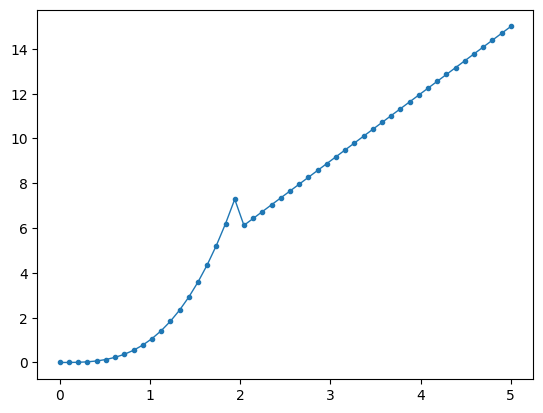

In [ ]:
x = np.linspace(0, 5, 50)
y = list(map(f, x))
plt.plot(x, y, "o-", markersize=3, lw=1)

## Expression Representation

One way to address expression swell is to adopt a more compact representation of the function $f$. Consider the function:

$$ f(x) = x^{3} $$ 

We may implement this function using the following computer program `f`:

In [ ]:
def f(x):
    x = x*x
    x = x*x
    x = x*x
    return x

We can represent `f` using an expression tree [[1]](/https://arxiv.org/pdf/1904.02990.pdf), which details how operations are sequentially performed on inputs to produce outputs.

<!-- We can represent this function as an expression tree [[1]](/https://arxiv.org/pdf/1904.02990.pdf): -->

<img src="../figures/expression_tree.png" height = 400 widht = 400/>

Whilst clear, this representation is obviously inefficient. For instance, the first `x*x` operation is represented four times in the third level of level of the tree, but it is only computed once in practice. Likewise, the second `x*x` operation is represented twice in the second level of the tree, but only computed once in reality. Moreover, the input variable `x` is represented eight times at the bottom of the tree.


Instead, it is far more efficient to represent `f` as an expression DAG:

<img src="../figures/expression_dag.png" />

Expression DAGs are also called **computational graphs**. Note that each operation in `f` is represented once in the computational graph. Likewise variables are only represented once. Due to their compact representation, computational graphs can be used to significantly mitigate expression swell. In fact, modern AD packages such as PyTorch, efficiently compute and store computation graphs to facilitate differentiation.

Consider the following function:

$$ f(x, y) = x^{2} + 4y + \cos^{2}(x) $$

We can implement $f$ as a program in PyTorch and visualise the resulting computational graph.

<!-- 
This representation form is known as the expression DAG, or computational graph, and is a much more efficient way to store the computational trace of a computer program. This type of representation solves the 'expresion swell' problem. -->

<!-- In reverse-mode AD packages such as PyTorch implement efficient ways of generating and storing the computational graph: -->

In [19]:
#!pip install torchviz

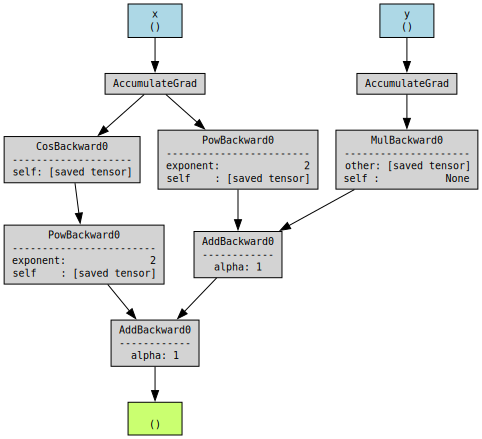

In [17]:
import torchviz

def f(x, y):
    return x**2 + 4 * y + torch.cos(x)**2

x = torch.tensor(2.0, requires_grad=True) # PyTorch only tracks the graph involving variables that require grad.
y = torch.tensor(1.5, requires_grad=True)
z = f(x, y)

torchviz.make_dot(z, params={"x" : x, "y" : y}, show_attrs=True)


Note that this computational graph is a property of the program `f` rather than the function $f$ that it implements. In other words, implementing $f$ via a different program would result in a different computational graph. For this reason, some people believe differentiation methods which leverage computational graphs should be called **algorithmic differentiation** methods rather than automatic differentiation methods.

Note: See [this reference](https://arxiv.org/pdf/1904.02990) for more details about the differences between automatic differentiation and symbolic differentiation.

## Forward and Reverse Mode Automatic Differentiation

Once we have stored the computation graph of a program, we can compute its derivative by applying the chain rule through each of the operations in the graph. This is essentially equivalent to the way derivatives are obtained in SD, but the compact representation of the graph leads to less expression swell. Of course, AD methods need hard-coded implementations for the derivatives of building block functions such as $cos$ and $exp$. For this reason, AD packages such as Tensorflow and Torch reimplement many simple functions so that they can be packaged with their derivative. This is why you need to call `tf.exp` or `torch.exp` instead of `math.exp` when writing differentiable code!

Let's return to our previous example. Note that, when applying the chain rule, we have two equivalent ways of traversing the computational graph. We can start at the initial nodes $(x, y)$ and propapgate the derivatives forward. Unsurpsiringly, this is called forward-mode AD. Alternatively, we can start at the final node $z$ and propagate derivatives backwards. This is known as reverse-mode AD. Both methods give identical results but come with different computational performance guarantees which we will now investigate.

<!-- In the diagram above, PyTorch has a differentiation rule for each of the rectangles that represent a function (i.e, Cos, Mul, Pow), etc. and we can easily obtain the total derivative by propagating through the chain rule.

Note, however, that we have two equivalent ways of traversing the graph. We can start by the initial nodes $(x, y)$ and propagate the derivatives forward, or we can start by the final node $z$ and propagate them backwards.
The former is known as Forward-mode AD and the latter corresponds to reverse-mode AD. Both give identical results but they exhibit different performance depending on the situation. -->

Consider the two functions $f_{1}: \mathbb{R} \to \mathbb{R}^{3}$ and $f_{2}: \mathbb{R}^{3} \to \mathbb{R}_{1}$:

$$ f_{1}(x_{1}) = \begin{bmatrix} x^{2}_{1} \\ x^{2}_{1} \\ x^{2}_{1}\end{bmatrix}, \quad
    f_{2}(x_{1}, x_{2}, x_{3}) = x_{1}^{2}x_{2}x_{3}$$

We can implement $f_{1}$ and $f_{2}$ with the below programs `f1` and `f2`:

In [ ]:
def f1(x1):
    x1 = x1 * x1
    x1 = x1 * x1
    return [x1, x1, x1]

def f2(x1, x2, x3):
    x1 = x1 * x2 * x3
    x1 = x1 * x1
    return x1

The computational graphs of `f1` and `f2` are:


<p float="left">
  <img src="../figures/multiple_outputs.png" height = 300 width="200" />
  <img src="../figures/multiple_inputs.png" height = 300 width="200" /> 
</p>

In the case of `f1`, if we start from the bottom ($x_1$) and chain derivatives forward, then we can reuse the intermediate computation between the 1st and 3rd nodes.
However, if we start at the final nodes $(f_1, f_2, f_3)$ and chain derivatives backwards, we need to fully traverse the graph three times since we can't amortize any part of the computation.
Note that reverse is true for $f_2$!

This example illustrates a more general result. Given a function 

$$f: \mathbb R^m \longrightarrow \mathbb R^n,$$

computation of the Jacobian

$$(J_f)_{ij} = \left(\frac{\partial f_i}{\partial x_{j}}\right)$$

scales as $\mathcal O(m)$ for forward-mode AD, and $\mathcal O(n)$ for reverse-mode AD. 

Put simply, we generally prefer forward-mode AD for functions with more outputs than inputs, whilst we generally prefer backwards-mode AD for functions with more inputs than outputs. In deep learning, we are predominantly concerned with training neural networks via gradient descent, which involves differentiation of a loss function with respect to neural network parameters. Most loss functions typically produce one output: the loss! In contrast, neural networks can have millions, or billions, of parameters. As a result, AD packages for machine learning, like PyTorch, typically prioritise reverse-mode AD. 

The story is slightly different for ABMs. Firstly, ABMs often have far fewer parameters than neural networks, making forward-mode AD a more practical option. Secondly, forward-mode AD has an additional advantage over reverse-mode AD that we are yet to discuss. To execute reverse-mode AD on a program `f`, we need to store the value of intermediary computations performed when `f` is evaluated, which is sometimes called the *forward pass*. This is so that we can apply the chain rule backwards later. Forward-mode AD has no such issue since we can throw away intermediate values and derivatives on the fly if we propoagate the chain rule forward as `f` is evaluated. As a result, forward-mode AD is far more memory efficient than reverse-mode AD. For large-scale ABMs with millions of interacting agents, there can be an extremely large number of intermediate computations, making reverse-mode AD intractable from a memory perspective. For more details, check out this [paper](https://arxiv.org/pdf/2307.01085).

<!-- most training of neural networks requires the differentiation of the loss function, which is a function of many inputs (number of neural network parameters) and one output (e.g., result of L2 loss). For this reason, most AD packages focus such as PyTorch is on reverse-mode AD. -->

To finish, let's verify the run time behaviour of forward and reverse AD experimentally. Consider a function $f: \mathbb{R}^{m} \to \mathbb{R}^{n}$  which given input $x = (x_{1}., \dots, x_{m})$ returns a constant vector $y =(y_{1}, \dots, y_{n})$ where each entry is equal to $\sum^{m}_{i=1}x_{i}$. We can play with input and output dimensions by playing with $m$ and $n$ respectively. We should expect the runtime performance of reverse-mode AD to depreciate linearly as the output dimension $n$ is increased. Meanwhile we should expect the runtime performance of forward-mode AD to depreciate linearly as the input dimension $m$ is increased. Let's plot the run times of forward and reverse mode AD as a function of $m$ and $n$ and see if this holds true!

<!-- Let's confirm the behaviour of forward and reverse AD by recording their wall clock time -->




In [ ]:
from time import time

def make_f(n_outputs):
    def _f(x):
        return torch.sum(x) * torch.ones(n_outputs)
    return _f

# scale number of outputs
inputs = torch.ones(10)
results = {"outputs" : {"forward" : [], "reverse" : []}, "inputs" : {"forward" : [], "reverse" : []}}
f_inputs = make_f(10)
#n_range = [1, 10, 100, 1000, 10000]
n_range = np.arange(1, 10) * 1000
for n in n_range:
    f = make_f(n)
    t1 = time()
    jacobian = torch.autograd.functional.jacobian(f, inputs, strategy="reverse-mode")
    t2 = time()
    results["outputs"]["reverse"].append(t2-t1)
    t1 = time()
    jacobian = torch.autograd.functional.jacobian(f, inputs, strategy="forward-mode", vectorize=True)
    t2 = time()
    results["outputs"]["forward"].append(t2-t1)
    varying_inputs = torch.ones(n)
    t1 = time()
    jacobian = torch.autograd.functional.jacobian(f_inputs, varying_inputs, strategy="reverse-mode")
    t2 = time()
    results["inputs"]["reverse"].append(t2-t1)
    t1 = time()
    jacobian = torch.autograd.functional.jacobian(f_inputs, varying_inputs, strategy="forward-mode", vectorize=True)
    t2 = time()
    results["inputs"]["forward"].append(t2-t1)

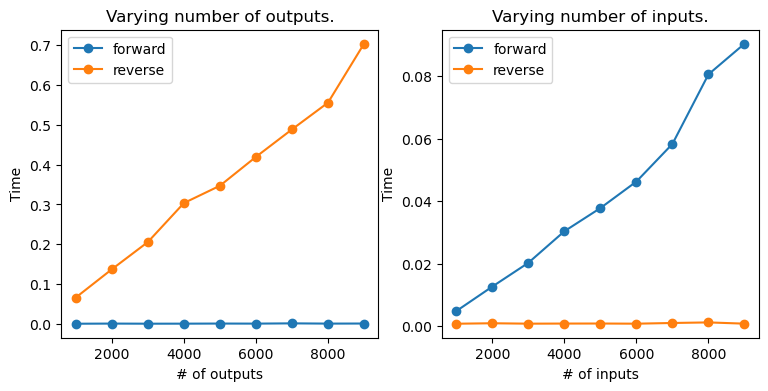

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].set_title("Varying number of outputs.")
ax[0].plot(n_range, results["outputs"]["forward"], "o-", label = "forward")
ax[0].plot(n_range, results["outputs"]["reverse"], "o-", label = "reverse")
ax[0].set_xlabel("# of outputs")
ax[0].set_ylabel("Time")
ax[0].legend()

ax[1].set_title("Varying number of inputs.")
ax[1].plot(n_range, results["inputs"]["forward"], "o-", label = "forward")
ax[1].plot(n_range, results["inputs"]["reverse"], "o-", label = "reverse")
ax[1].set_xlabel("# of inputs")
ax[1].set_ylabel("Time")
ax[1].legend()


As expected, our suspicions are well verified by the plots above!

## Summary

In this notebook we covered traditional methods for differentiation including finite differentiation and symbolic differentiation. After highlighting their weaknesses, we introduced automatic differentiation and explored the computational differences between forward-mode and reverse-mode. In the next notebook, we will investigate the common challenges faced when applying automatic differentiation to ABMs.